In [1]:
rm(list=ls())
setwd("/scratch/AG_Ohler/CheWei/kallisto-bus/output/Integration/")

In [2]:
libs <- c("here", "dplyr", "tradeSeq", "SingleCellExperiment", "slingshot",
           "condiments", "scater", "RColorBrewer", "pheatmap", "cowplot",
          "tidyr","condimentsPaper","Seurat")
suppressMessages(
  suppressWarnings(sapply(libs, require, character.only = TRUE))
)

here                dplyr             tradeSeq 
                TRUE                 TRUE                 TRUE 
SingleCellExperiment            slingshot           condiments 
                TRUE                 TRUE                 TRUE 
              scater         RColorBrewer             pheatmap 
                TRUE                 TRUE                 TRUE 
             cowplot                tidyr      condimentsPaper 
                TRUE                 TRUE                 TRUE 
              Seurat 
                TRUE

In [3]:
suppressPackageStartupMessages({
  library(slingshot); library(SingleCellExperiment)
  library(RColorBrewer); library(scales)
  library(viridis); library(UpSetR)
  library(pheatmap); library(msigdbr)
  library(fgsea); library(knitr)
  library(ggplot2); library(gridExtra)
  library(tradeSeq);library(Seurat)
  library(tidyverse);library(condiments)
  library(patchwork);library(ComplexHeatmap)
  library(circlize)  
})

Warning message:
“package ‘viridis’ was built under R version 4.1.1”
Warning message:
“package ‘knitr’ was built under R version 4.1.2”
Warning message:
“package ‘tibble’ was built under R version 4.1.1”
Warning message:
“package ‘readr’ was built under R version 4.1.2”


In [4]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/tradeseq/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] circlize_0.4.14             ComplexHeatmap_2.10.0      
 [3] patchwork_1.1.1             forcats_0.5.1              
 [5] stringr_1.4.0               purrr_0.3.4                
 [7] readr_2.1.2                 tibble_3.1.6               
 [9] tidyverse_1.3.1       

In [5]:
## Load BR_time_course downloaded from GEO:GSE212230
rc.integrated <- readRDS("./BR_time_course.rds")

In [19]:
# subset only samples you want to compare
integrated.de <- subset(rc.integrated, subset = sample %in% c( "sc_43", "sc_44","sc_45","sc_46","sc_47","sc_48","sc_49","sc_50"))

In [24]:
integrated.de$treatment <- factor(integrated.de$treatment, levels=c("BRZ", "BL 0.5 hour", "BL 1 hour","BL 2 hour","BL 4 hour","BL 8 hour"))

In [25]:
table(integrated.de$treatment)


        BRZ BL 0.5 hour   BL 1 hour   BL 2 hour   BL 4 hour   BL 8 hour 
      13961        6843        6336       12485        6907        6389 

In [26]:
# Extract only cortex cells
cortex.de <- subset(integrated.de, subset = cell_type %in% c( "Cortex"))

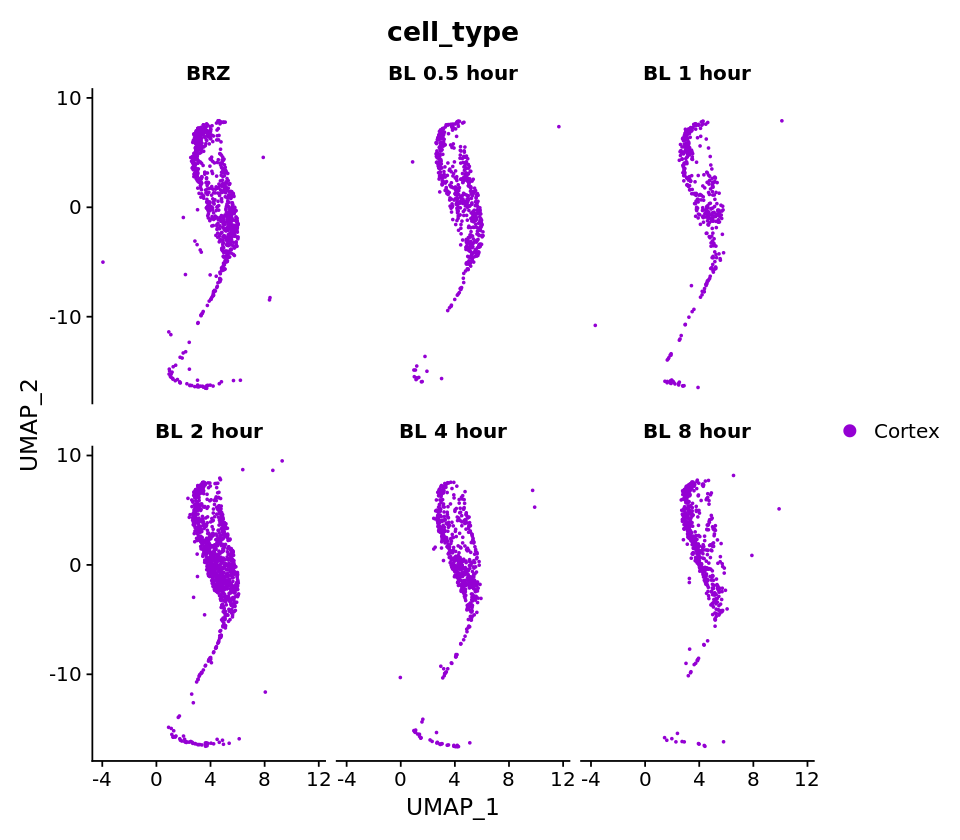

In [27]:
options(repr.plot.width=8, repr.plot.height=7)
(DimPlot(cortex.de, reduction = "umap", group.by = "cell_type", cols = color, split.by = 'treatment', ncol=3))

In [28]:
## Merge proliferation and transition domain into meristem
cortex.de$time_zone2 <- cortex.de$time_zone
cortex.de$time_zone2 <- gsub("Proliferation Domain","Meristem",cortex.de$time_zone2)
cortex.de$time_zone2 <- gsub("Transition Domain","Meristem",cortex.de$time_zone2)

## CytoTRACE

In [29]:
suppressMessages(library(CytoTRACE))

Warning message:
“The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application.”


In [30]:
dat <- as.matrix(cortex.de@assays$SCT@data)

In [31]:
# Run CytoTRACE
results <- CytoTRACE(dat, ncores = 16, subsamplesize = 1000)

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

Warning message in CytoTRACE(dat, ncores = 16, subsamplesize = 1000):
“3014 genes have zero expression in the matrix and were filtered”
CytoTRACE will be run on 4 sub-sample(s) of approximately 1072 cells each using 4 / 16 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



In [32]:
cortex.de$CytoTRACE <- results$CytoTRACE
cortex.de$CytoTRACE_pseudotime <- 1-results$CytoTRACE

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



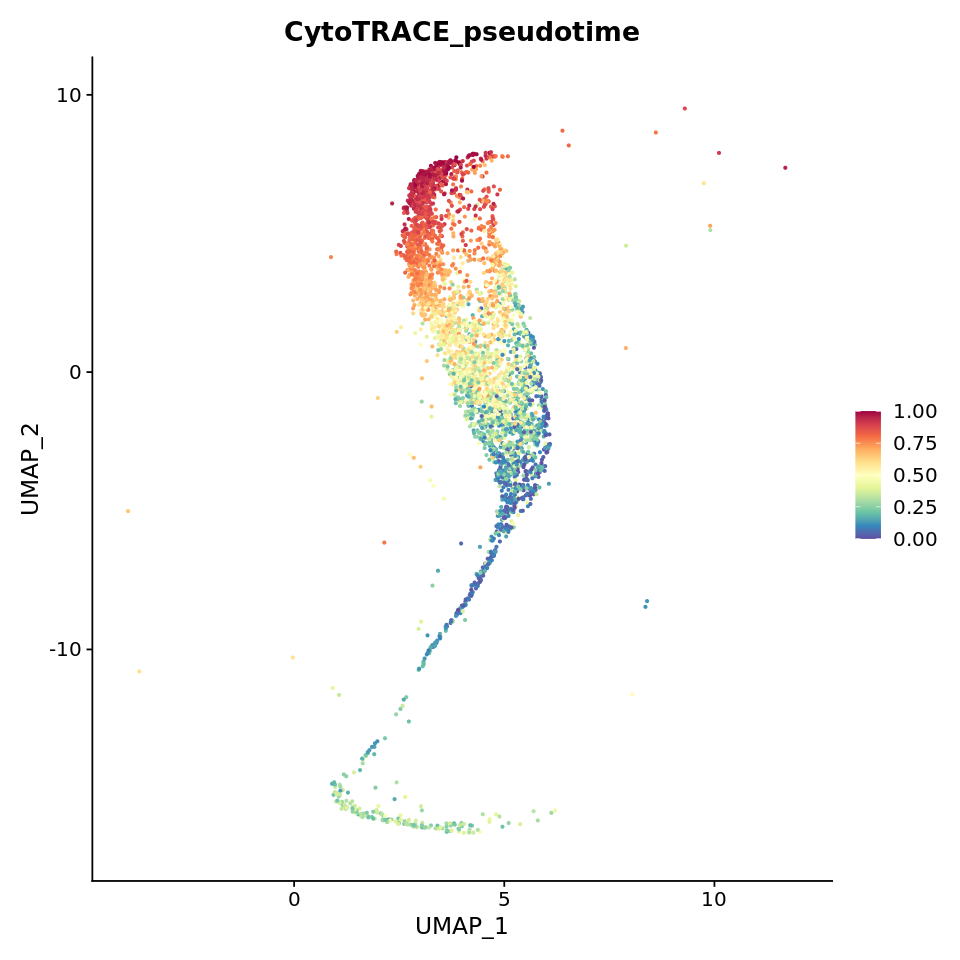

In [33]:
# Plot CytoTRACE
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(cortex.de, features = "CytoTRACE_pseudotime", pt.size=0.5)+ scale_colour_gradientn(colours = rev(brewer.pal(11,"Spectral")))

## Convert Seurat to singleCellExperiment

In [34]:
sce <- as.SingleCellExperiment(cortex.de, assay = "RNA")

In [35]:
sce

class: SingleCellExperiment 
dim: 28725 4287 
metadata(0):
assays(2): counts logcounts
rownames(28725): AT1G01010 AT1G01020 ... AT4G23310 AT4G23580
rowData names(0):
colnames(4287): AAACCCACAAGCAATA_5 AAAGAACAGAGGTGCT_5 ...
  TTCTAGTCAGTTAGAA_12 TTGCTGCTCTAACGGT_12
colData names(27): sample name ... CytoTRACE_pseudotime ident
reducedDimNames(4): PCA UMAP UMAP_3D UMAP_2D
mainExpName: RNA
altExpNames(0):

In [36]:
table(sce$time_zone2, sce$treatment)

            
             BRZ BL 0.5 hour BL 1 hour BL 2 hour BL 4 hour BL 8 hour
  Elongation 372         292       199       733       479       413
  Maturation 155          46        51        71        26        58
  Meristem   378         234       124       421       135       100

In [37]:
df <- bind_cols(
  as.data.frame(reducedDims(sce)$UMAP),
    as.data.frame(sce$CytoTRACE_pseudotime),
    as.data.frame(sce$treatment)
    )
    

colnames(df) <- c("UMAP_1","UMAP_2","CytoTRACE_pseudotime","treatment")

#curve <- slingCurves(sce)[[1]]

In [38]:
colnames(df)

[1] "UMAP_1"               "UMAP_2"               "CytoTRACE_pseudotime"
[4] "treatment"

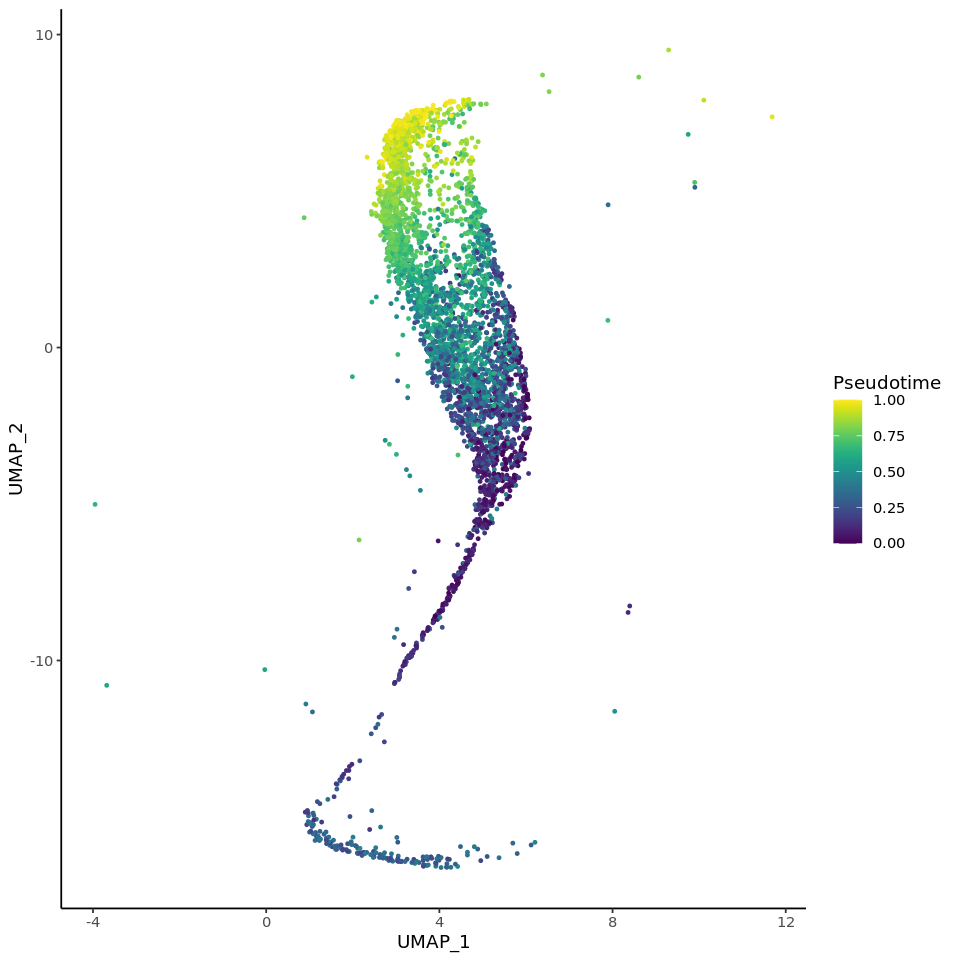

In [39]:
p4_no_curve <- ggplot(df, aes(x = UMAP_1, y = UMAP_2, col = CytoTRACE_pseudotime)) +
  geom_point(size = .7) +
  scale_color_viridis() +
  labs(col = "Pseudotime")
p4_no_curve + theme_classic()

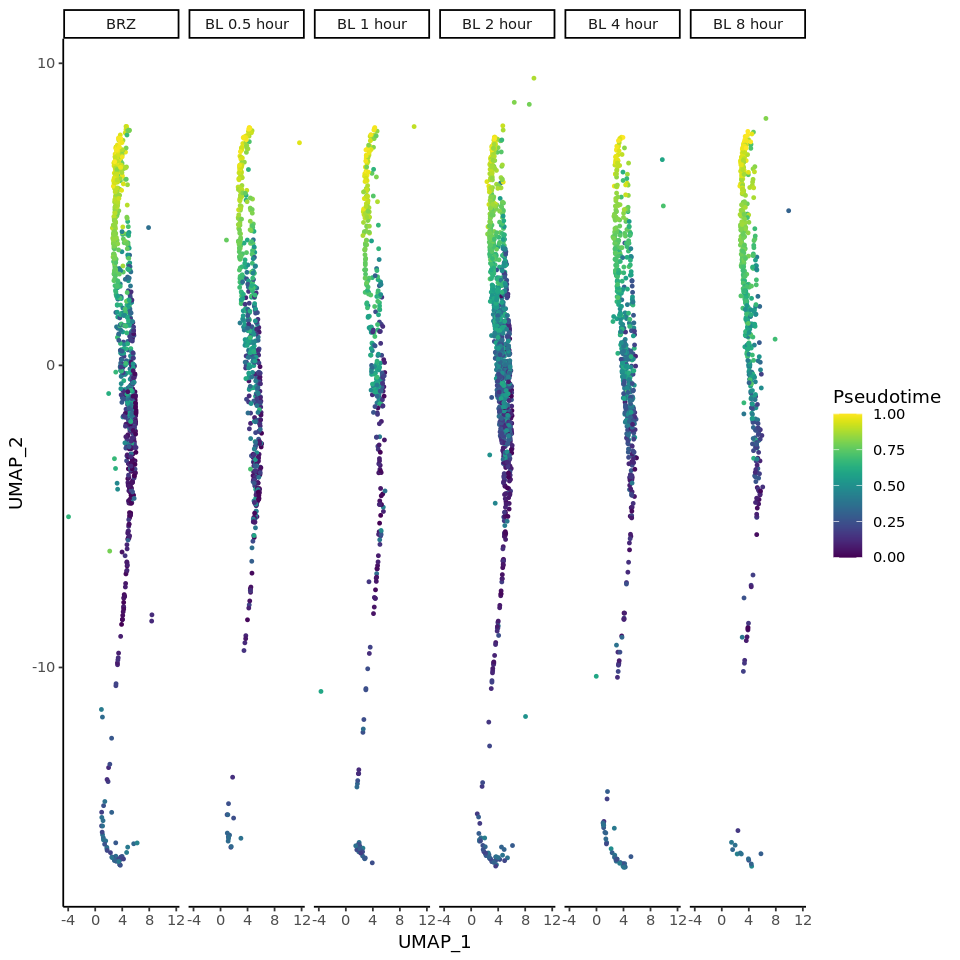

In [40]:
p4_no_curve + theme_classic()+facet_grid(~treatment)

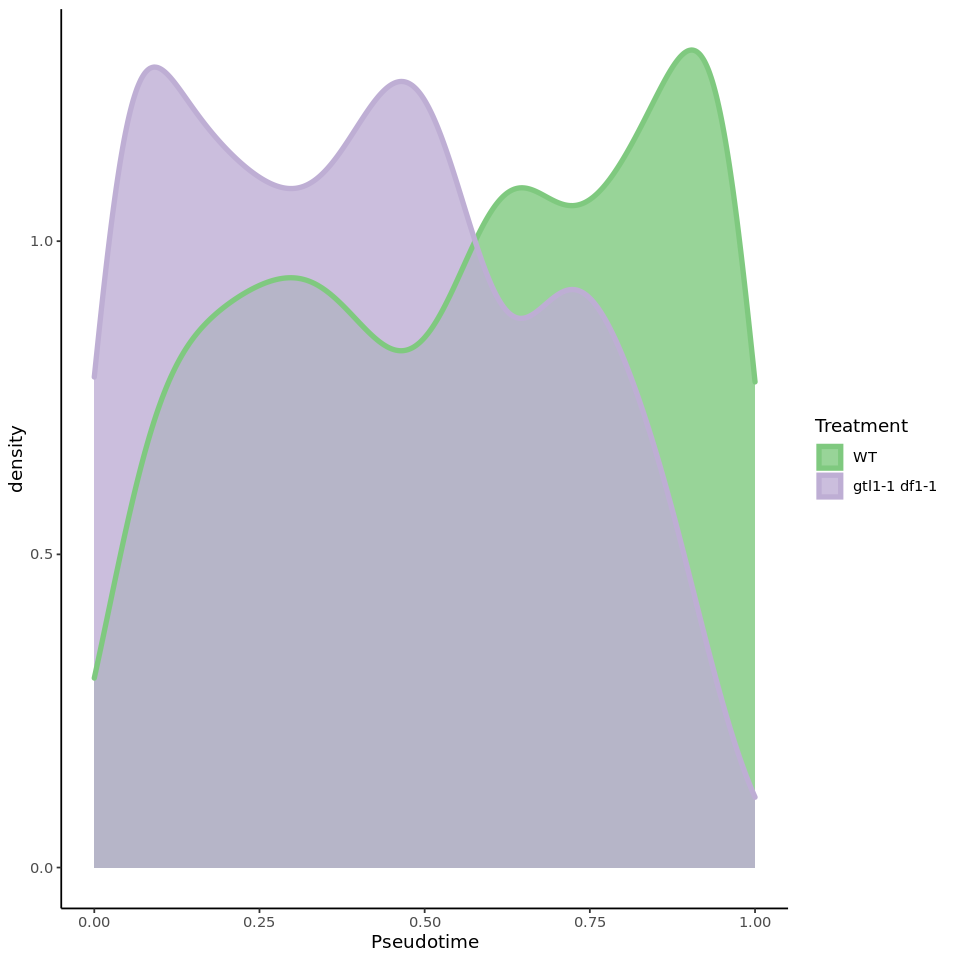

In [51]:
#p5 + theme_classic()

In [41]:
saveRDS(sce, "./cortex_de_br_sce.rds")

In [42]:
sce <- readRDS("./cortex_de_br_sce.rds")

In [43]:
sce

class: SingleCellExperiment 
dim: 28725 4287 
metadata(0):
assays(2): counts logcounts
rownames(28725): AT1G01010 AT1G01020 ... AT4G23310 AT4G23580
rowData names(0):
colnames(4287): AAACCCACAAGCAATA_5 AAAGAACAGAGGTGCT_5 ...
  TTCTAGTCAGTTAGAA_12 TTGCTGCTCTAACGGT_12
colData names(27): sample name ... CytoTRACE_pseudotime ident
reducedDimNames(4): PCA UMAP UMAP_3D UMAP_2D
mainExpName: RNA
altExpNames(0):

## Fit GAM

In [45]:
library(BiocParallel)
BPPARAM <- BiocParallel::bpparam()
#BPPARAM$workers <- parallel::detectCores() - 2
BPPARAM$workers <- 4

Warning message:
“package ‘BiocParallel’ was built under R version 4.1.1”


In [46]:
BPPARAM$workers

[1] 4

In [44]:
pseudotime <- as.matrix(sce$CytoTRACE_pseudotime)

In [ ]:
set.seed(33)
sce <- fitGAM(counts = sce@assays@data$counts, nknots = 6,
               conditions = factor(sce$treatment),
               pseudotime = pseudotime,
               cellWeights = matrix(1,nrow = nrow(pseudotime), ncol = ncol(pseudotime)),
               parallel = TRUE,
               BPPARAM = BPPARAM
               )
mean(rowData(sce)$tradeSeq$converged)

Fitting lineages with multiple conditions. This method has been tested on a couple of datasets, but is still in an experimental phase.

iteration: 


## Heatmap of genes DE among conditions

In [5]:
sce <- readRDS("./cortex_de_br_sce.rds")

In [44]:
options(repr.plot.width=12, repr.plot.height=6)

In [39]:
DE_163 <- read.csv("../../../proj_sc/cbpsc/BL_up_bri1_T_down_WT_cortex_traj_163.csv")

In [40]:
yhatSmooth <- predictSmooth(sce, gene = unique(DE_163$GeneID), nPoints = 50, tidy = FALSE) %>%
  log1p()

In [41]:
yhatSmooth <- predictSmooth(sce, gene = unique(DE_163$GeneID), nPoints = 50, tidy = FALSE) %>%
  log1p()
#reorder based on BRZ pseudotime
yhatSmooth <- yhatSmooth[order(apply(yhatSmooth[ ,  150:200],1,which.max)), ]

yhatSmoothScaled <- t(apply(yhatSmooth,1, scales::rescale))

show.label <- c("HAT7", "GTL1", "C/VIF2", "CESA5", "HERK2", "HA2")
show.id <- c("AT5G15150", "AT1G33240", "AT5G64620","AT5G09870","AT1G30570", "AT4G30190")

mark_anno = rowAnnotation(foo = anno_mark(at = match(show.id,rownames(yhatSmoothScaled)), labels = show.label, labels_gp = gpar(col = "black", fontsize = 16)))

col_fun = colorRamp2(c(0.02,1), c("white","darkgreen"))

ha = HeatmapAnnotation(Pseudotime=c(seq(0.02,1,by=1/50),seq(0.02,1,by=1/50),seq(0.02,1,by=1/50),seq(0.02,1,by=1/50),seq(0.02,1,by=1/50),seq(0.02,1,by=1/50)), col = list(Pseudotime = col_fun), show_annotation_name = F,show_legend = F,
                      annotation_legend_param = list(title_position="topcenter", title = "CytoTRACE Pseudotime", direction="horizontal", legend_width = unit(4, "cm")))

H1 <- Heatmap(yhatSmoothScaled,column_split = factor(c(rep("BRZ",50),rep("BL 0.5 hour",50),rep("BL 1 hour",50),rep("BL 2 hour",50),rep("BL 4 hour",50),rep("BL 8 hour",50)), levels=c("BRZ", "BL 0.5 hour", "BL 1 hour", "BL 2 hour", "BL 4 hour", "BL 8 hour" )), 
        col = colorRampPalette(rev(brewer.pal(n = 7, name =
  "RdYlBu")))(100),
                show_column_names = F,
                cluster_columns = F,
                cluster_rows=F,
                show_row_names = F, 
                right_annotation=mark_anno,
                show_heatmap_legend=F,
                use_raster=F,
              bottom_annotation=ha,
               heatmap_legend_param = list(title_position="topcenter", title = "Expression", direction="horizontal"))

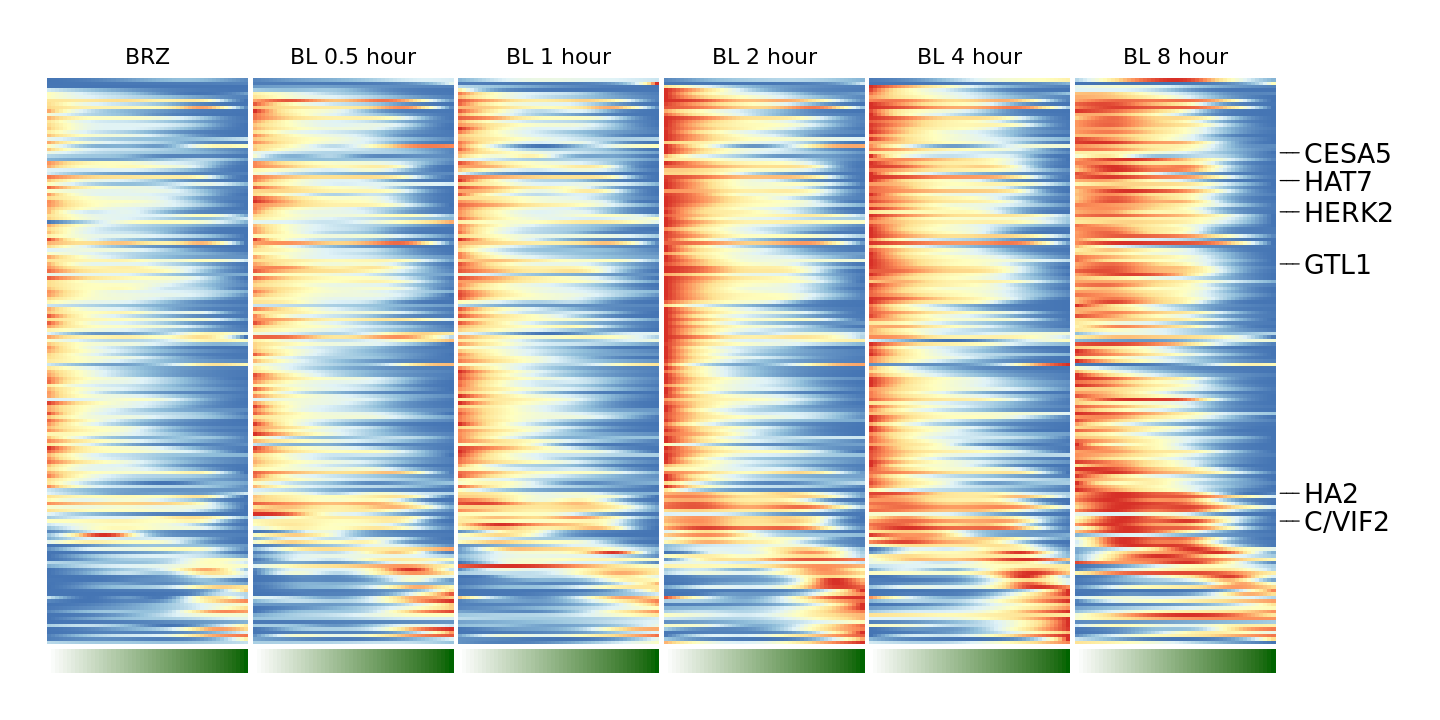

In [45]:
draw(H1, heatmap_legend_side = "right", legend_labels_gp = gpar(fontsize = 12, fontface = "plain"), padding = unit(c(1, 1, 1, 1), "cm"))

In [46]:
pdf("BR_163genes_cortex.pdf", height=6, width=12)
draw(H1, heatmap_legend_side = "right", legend_labels_gp = gpar(fontsize = 12, fontface = "plain"), padding = unit(c(1, 1, 1, 1), "cm"))
dev.off()

png 
  2